## Import Libraries and Configure Visualization

Import necessary libraries for data analysis and visualization, and configure matplotlib and seaborn for consistent styling.

In [11]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

## Load Data from Multiple CSV Files

Load and concatenate CSV files from three data folders (biometric, demographic, and enrolment) and display their shapes.

In [3]:
def load_folder(folder_path):
    dfs = []
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            dfs.append(pd.read_csv(os.path.join(folder_path, file)))
    return pd.concat(dfs, ignore_index=True)

bio_df    = load_folder("api_data_aadhar_biometric")
demo_df   = load_folder("api_data_aadhar_demographic")
enroll_df = load_folder("api_data_aadhar_enrolment")

print(enroll_df.shape, demo_df.shape, bio_df.shape)

(1006029, 7) (2071700, 6) (1861108, 6)


## Data Normalization and Preprocessing

Clean column names, normalize state names to consistent format, parse dates, and create month/year columns. Drop the pincode column as a critical fix.

In [4]:
def normalize_and_preprocess(df):
    # Clean column names
    df.columns = df.columns.str.strip()
    
    # Normalize state
    df['state'] = (
        df['state']
        .str.strip()
        .str.lower()
        .replace({
            'westbengal': 'west bengal',
            'tamilnadu': 'tamil nadu',
            'orissa': 'odisha',
            'dadra & nagar haveli': 'dadra and nagar haveli',
            'chhatisgarh': 'chhattisgarh',
        })
    )
    
    # Parse date
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
    df['month'] = df['date'].dt.to_period("M")
    df['year']  = df['date'].dt.year
    
    # DROP PINCODE — critical fix
    df.drop(columns=['pincode'], inplace=True, errors='ignore')
    
    return df

enroll_df = normalize_and_preprocess(enroll_df)
demo_df   = normalize_and_preprocess(demo_df)
bio_df    = normalize_and_preprocess(bio_df)


## Aggregate Data by Month and State

Group data by month and state to create aggregated statistics for each dataset.

In [5]:
enroll_agg = enroll_df.groupby(['month','state'], as_index=False).sum(numeric_only=True)
demo_agg   = demo_df.groupby(['month','state'], as_index=False).sum(numeric_only=True)
bio_agg    = bio_df.groupby(['month','state'], as_index=False).sum(numeric_only=True)

## Rename Columns for Clarity

Standardize column names across the aggregated datasets for easier identification and merging.

In [6]:
enroll_agg = enroll_agg.rename(columns={
    'age_5_17': 'enroll_5_17',
    'age_18_greater': 'enroll_18p'
})

demo_agg = demo_agg.rename(columns={
    'demo_age_5_17': 'demo_5_17',
    'demo_age_17_': 'demo_18p'
})

bio_agg = bio_agg.rename(columns={
    'bio_age_5_17': 'bio_5_17',
    'bio_age_17_': 'bio_18p'
})

print("Enrollment:", enroll_agg.columns.tolist())
print("Demographic:", demo_agg.columns.tolist())
print("Biometric:", bio_agg.columns.tolist())

Enrollment: ['month', 'state', 'age_0_5', 'enroll_5_17', 'enroll_18p', 'year']
Demographic: ['month', 'state', 'demo_5_17', 'demo_18p', 'year']
Biometric: ['month', 'state', 'bio_5_17', 'bio_18p', 'year']


## Merge Datasets

Merge enrollment, demographic, and biometric aggregated data on month and state to create a unified dataset.

In [7]:
df = (
    enroll_agg
    .merge(demo_agg[['month','state','demo_5_17','demo_18p']], on=['month','state'], how='left')
    .merge(bio_agg[['month','state','bio_5_17','bio_18p']], on=['month','state'], how='left')
)

display(df.head())


,month,state,age_0_5,enroll_5_17,enroll_18p,year,demo_5_17,demo_18p,bio_5_17,bio_18p
0,2025-03,andhra pradesh,43,44,29,4050,48600.0,464440.0,243777.0,159519.0
1,2025-03,assam,587,1105,800,60750,16692.0,185345.0,59101.0,33830.0
2,2025-03,bihar,516,1392,444,44550,95221.0,991478.0,324179.0,439330.0
3,2025-03,chhattisgarh,115,46,99,6075,18699.0,282767.0,37255.0,134137.0
4,2025-03,delhi,181,102,85,8100,24234.0,242085.0,62172.0,102196.0


## Calculate Completion Rates

Compute demographic and biometric completion rates by dividing completed counts by enrollment counts for both age groups.

In [8]:
df[['enroll_18p','enroll_5_17']] = df[['enroll_18p','enroll_5_17']].replace(0, np.nan)

df['demo_rate_18p'] = df['demo_18p'] / df['enroll_18p']
df['bio_rate_18p']  = df['bio_18p']  / df['enroll_18p']

df['demo_rate_5_17'] = df['demo_5_17'] / df['enroll_5_17']
df['bio_rate_5_17']  = df['bio_5_17']  / df['enroll_5_17']

df.replace([np.inf, -np.inf], np.nan, inplace=True)


## Descriptive Statistics for Biometric Rate (18+)

Print summary statistics for the biometric completion rate of 18+ age group.

In [9]:
print(df['bio_rate_18p'].describe())


count      256.000000
mean      1047.209111
std       2762.007813
min          0.957645
25%        123.037429
50%        342.689784
75%        825.370891
max      33688.400000
Name: bio_rate_18p, dtype: float64


## Distribution Analysis of Biometric Rate (18+)

Visualize the distribution of biometric completion rates using histogram, KDE, boxplot, and log-transformed histogram. Calculate skewness and kurtosis to understand data shape.

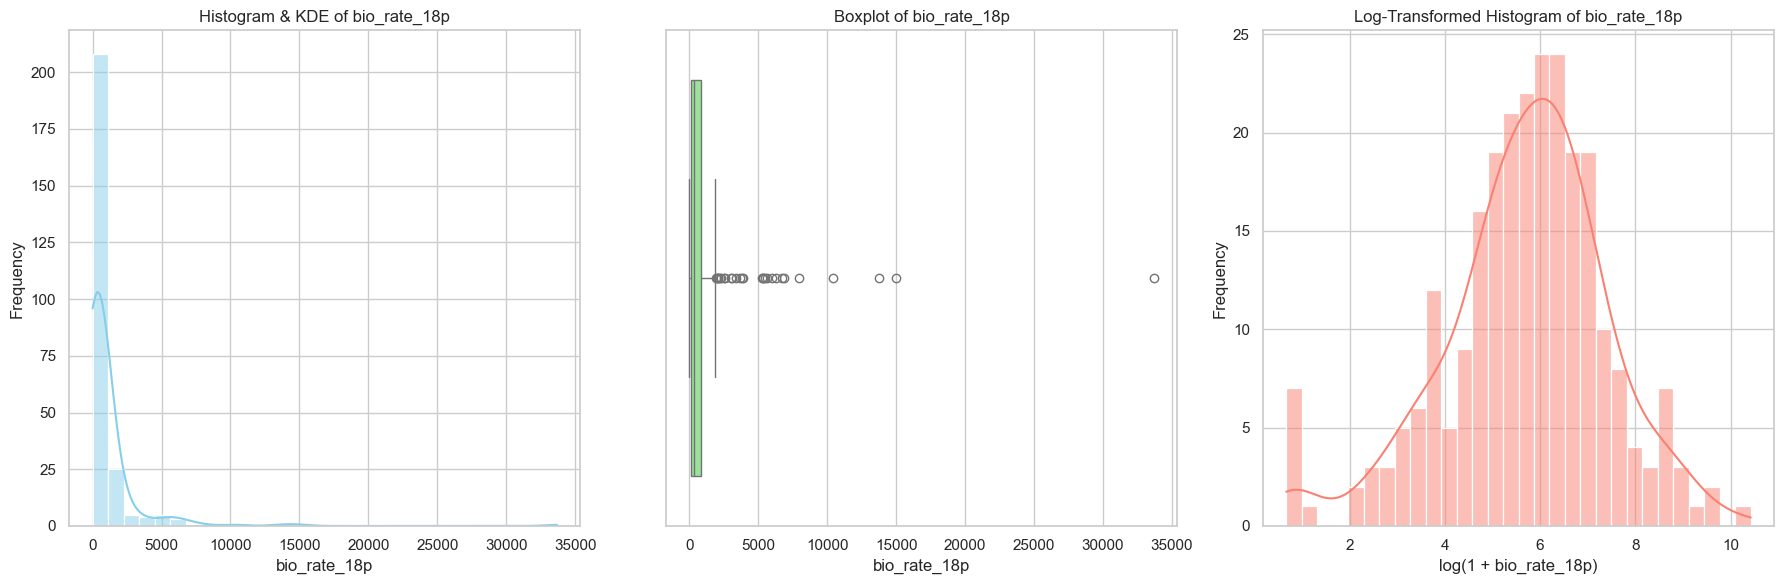

Number of NaNs: 45
Number of infinite values: 0
Skewness: 7.782083788045081
Kurtosis: 79.15209071289507


<Figure size 1000x500 with 0 Axes>

In [12]:
# Data
data = df['bio_rate_18p']

# Create a figure
plt.figure(figsize=(18,6))

# 1. Histogram + KDE (distribution)
plt.subplot(1,3,1)
sns.histplot(data, bins=30, kde=True, color='skyblue')
plt.title('Histogram & KDE of bio_rate_18p')
plt.xlabel('bio_rate_18p')
plt.ylabel('Frequency')

# 2. Boxplot (to check outliers)
plt.subplot(1,3,2)
sns.boxplot(x=data, color='lightgreen')
plt.title('Boxplot of bio_rate_18p')

# 3. Log-transformed Histogram (for skewed data)
plt.subplot(1,3,3)
sns.histplot(np.log1p(data), bins=30, kde=True, color='salmon')  # log1p avoids log(0)
plt.title('Log-Transformed Histogram of bio_rate_18p')
plt.xlabel('log(1 + bio_rate_18p)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
plt.savefig("bio_rate_18p_distribution.png", dpi=300)


# Check for NaNs and infinite values
print("Number of NaNs:", df['bio_rate_18p'].isna().sum())
print("Number of infinite values:", np.isinf(df['bio_rate_18p']).sum())

# Remove/fix them
data_clean = df['bio_rate_18p'].replace([np.inf, -np.inf], np.nan).dropna()

# Now calculate skewness and kurtosis

print("Skewness:", skew(data_clean))
print("Kurtosis:", kurtosis(data_clean))



### Graph Interpretation: Biometric Completion Rate Distribution Analysis

This visualization examines the distribution of biometric completion rates across the population with three complementary perspectives:

**Left Panel (Histogram & KDE)**: Visualizes the frequency distribution of biometric completion rates overlaid with a smooth kernel density estimate (KDE). This helps identify whether the data is unimodal (single peak) or multimodal (multiple peaks), and reveals the overall shape of the distribution.

**Middle Panel (Boxplot)**: Presents the statistical summary through quartiles, median line, and outliers. The boxplot effectively displays the interquartile range (IQR), showing the spread of the middle 50% of the data and highlighting any extreme values that may indicate data quality issues or exceptional enrollment cases.

**Right Panel (Log-Transformed Histogram)**: Applies a logarithmic transformation to the data to reveal hidden patterns, particularly useful for highly skewed distributions. This transformation helps determine if the data follows a power-law or log-normal distribution, which is common in population-based metrics.

**Statistical Summary**: The skewness and kurtosis metrics quantify the distribution characteristics. Positive skewness indicates a right tail (more extreme values on the high end), while kurtosis measures the heaviness of the tails relative to a normal distribution.

## State-wise Average Biometric Completion Rate (Log Scale Analysis)

Calculate average biometric completion rate per state and display as a horizontal bar chart sorted by rate. A logarithmic scale is used to better visualize the wide range of completion rates across states and highlight relative differences in lower-performing regions.

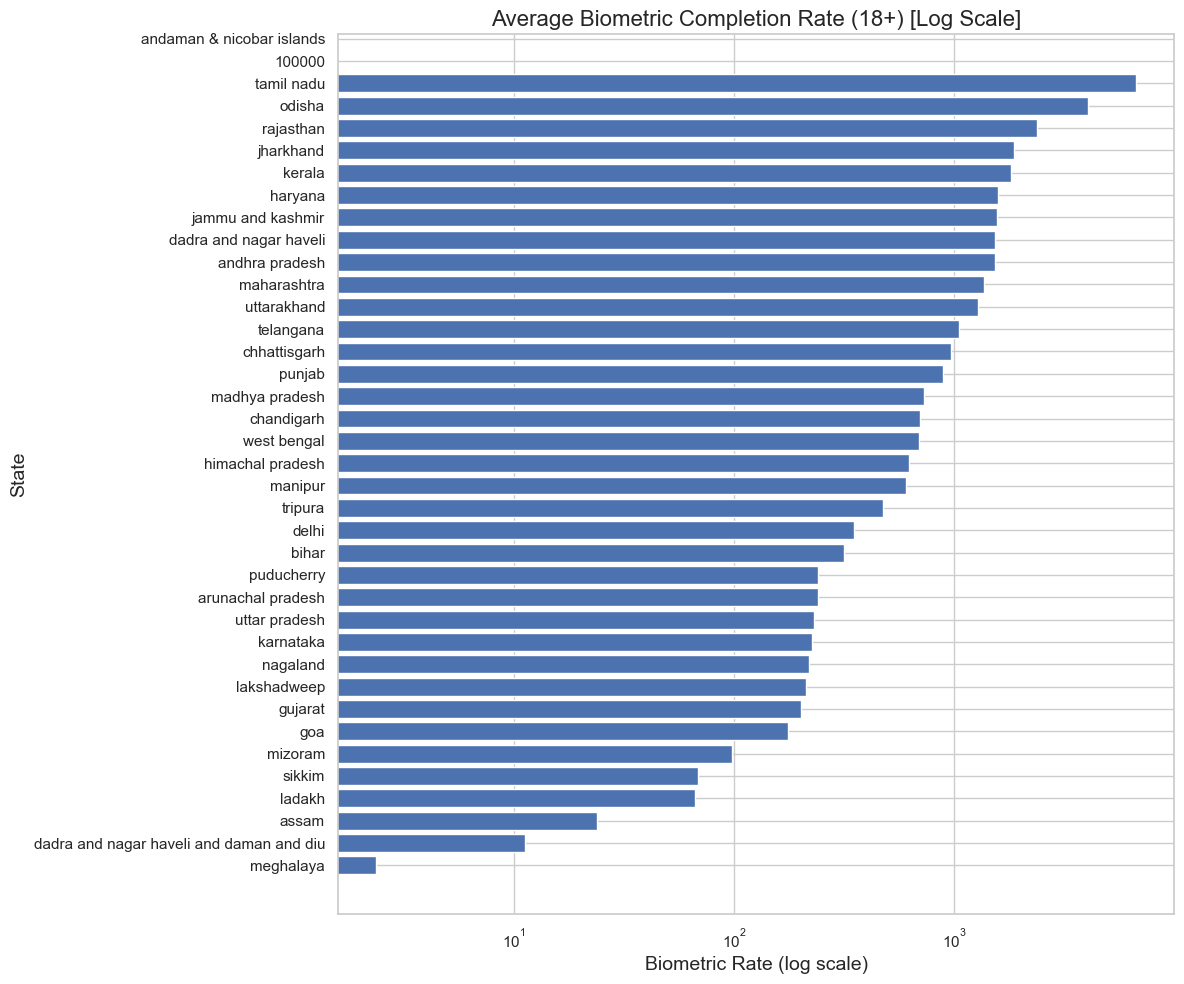

In [13]:
state_avg = df.groupby('state')['bio_rate_18p'].mean().sort_values()

plt.figure(figsize=(12, 10))
plt.barh(state_avg.index, state_avg.values)

plt.xscale('log')  # key change

plt.title("Average Biometric Completion Rate (18+) [Log Scale]", fontsize=16)
plt.xlabel("Biometric Rate (log scale)", fontsize=14)
plt.ylabel("State", fontsize=14)

plt.tight_layout()
plt.savefig("avg_biometric_completion_rate_18plus_log.png", dpi=300)
plt.show()


### Graph Interpretation: State-wise Biometric Rates

This horizontal bar chart ranks all states by their average biometric completion rates for the 18+ age group. States on the left have lower completion rates (worse performance), while states on the right have higher rates (better performance). This visualization makes it easy to:

- Identify which states need immediate intervention due to low biometric completion
- Compare state-level performance at a glance
- Prioritize resources for states with the lowest completion rates
- Track progress over time by comparing against future measurements

States with very short bars (close to zero or near the bottom) indicate critical gaps in biometric data collection infrastructure or implementation challenges.

## Monthly Trend Analysis

Visualize the trend of biometric completion rates over time (monthly) for the 18+ age group.

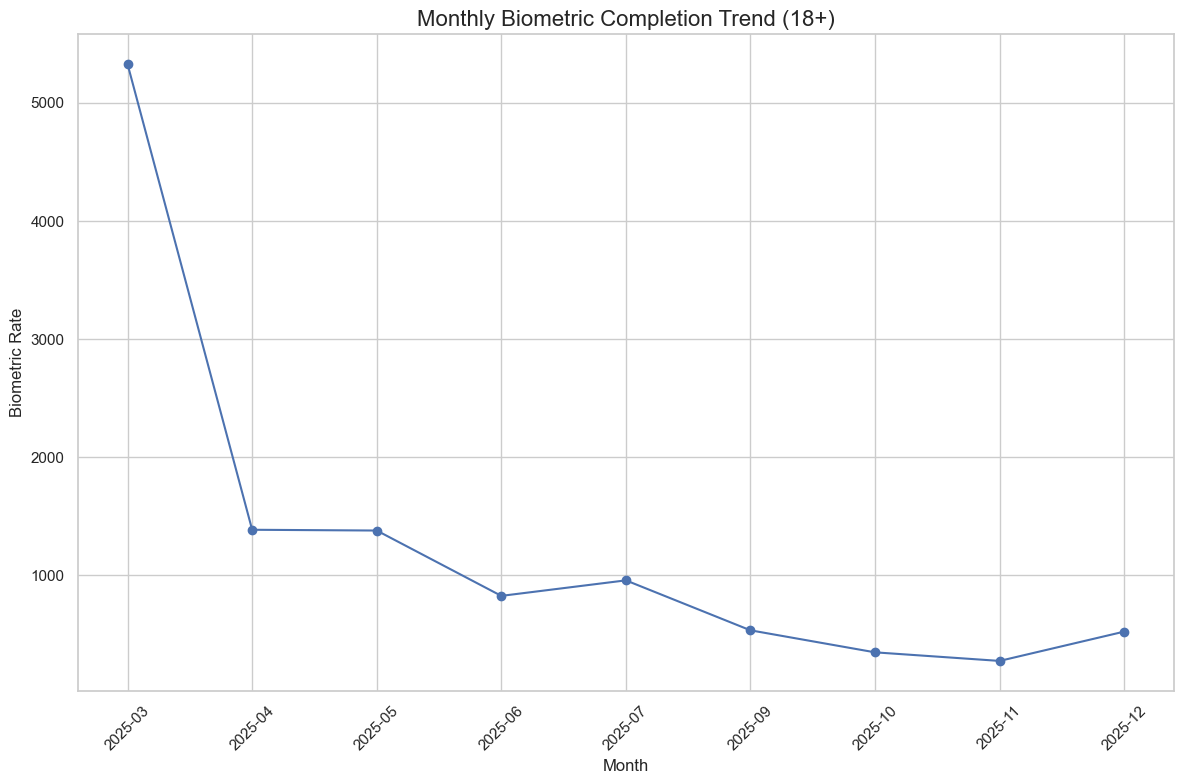

In [14]:
monthly = df.groupby('month')['bio_rate_18p'].mean()

plt.figure(figsize=(12,8))
plt.plot(monthly.index.astype(str), monthly.values, marker='o')
plt.title("Monthly Biometric Completion Trend (18+)", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Biometric Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("monthly_biometric_completion_18plus.png", dpi=300)
plt.show()


### Graph Interpretation: Monthly Trend Analysis

This line plot tracks how biometric completion rates for the 18+ age group evolve over time. Key insights from this visualization:

- **Trend Direction**: Upward trends indicate improving biometric data collection, while downward trends suggest deterioration
- **Seasonality**: Recurring patterns in the data might indicate seasonal factors (e.g., higher completion in certain months)
- **Volatility**: Sharp fluctuations might indicate operational changes, policy adjustments, or data collection challenges
- **Recent Performance**: The rightmost point shows the most recent month's performance
- **Overall Growth Rate**: Comparing early and recent months reveals the long-term trajectory of the program

This metric is crucial for program management as it helps identify whether interventions are effective in improving completion rates over time.

## Anomaly Detection

Identify anomalies by finding records where biometric rate is below the 5th percentile or equals zero.

In [15]:
low_threshold = df['bio_rate_18p'].quantile(0.05)


df['low_anomaly']  = df['bio_rate_18p'] < low_threshold
df['zero_anomaly'] = df['bio_rate_18p'] == 0

anomalies = df[df['low_anomaly'] | df['zero_anomaly']]

display(anomalies[['month','state','bio_rate_18p']])


,month,state,bio_rate_18p
11,2025-03,meghalaya,10.675711
18,2025-04,assam,7.602655
31,2025-04,meghalaya,1.138464
56,2025-05,meghalaya,1.216131
79,2025-06,meghalaya,1.586293
93,2025-07,assam,8.357184
108,2025-07,meghalaya,1.026346
150,2025-09,meghalaya,1.531781
195,2025-10,meghalaya,1.472669
216,2025-11,assam,12.205190


### Table Interpretation: Anomalies

The displayed table shows all records where biometric completion is anomalously low:

- **Records with bio_rate_18p < 5th percentile**: These represent state-month combinations where biometric collection is significantly below the typical baseline, suggesting operational or systemic issues
- **Records with bio_rate_18p = 0**: Complete absence of biometric data collection, indicating either no enrollment activity or a critical data collection failure

Examining the months and states involved helps identify:
- Geographic hotspots where biometric collection is consistently problematic
- Temporal patterns (e.g., specific months when performance drops)
- Potential operational bottlenecks or resource constraints
- States requiring urgent intervention and support

## Data Type Conversion and Anomaly Recalculation

Convert month from Period to Timestamp format, ensure numeric types, and recalculate anomalies after cleaning.

In [16]:
# Convert month from Period to Timestamp
if pd.api.types.is_period_dtype(df['month']):
    df['month'] = df['month'].dt.to_timestamp()

# Ensure bio_rate_18p is numeric
df['bio_rate_18p'] = pd.to_numeric(df['bio_rate_18p'], errors='coerce')
df = df.dropna(subset=['bio_rate_18p'])

# Recalculate anomalies
low_threshold = df['bio_rate_18p'].quantile(0.05)
df['low_anomaly']  = df['bio_rate_18p'] < low_threshold
df['zero_anomaly'] = df['bio_rate_18p'] == 0
anomalies = df[df['low_anomaly'] | df['zero_anomaly']]


C:\Users\prasi\AppData\Local\Temp\ipykernel_6208\2021444397.py:2: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(df['month']):


## Visualize Anomalies on Scatter Plot

Create a scatter plot to visualize the temporal and spatial distribution of low/zero biometric rate anomalies across states.

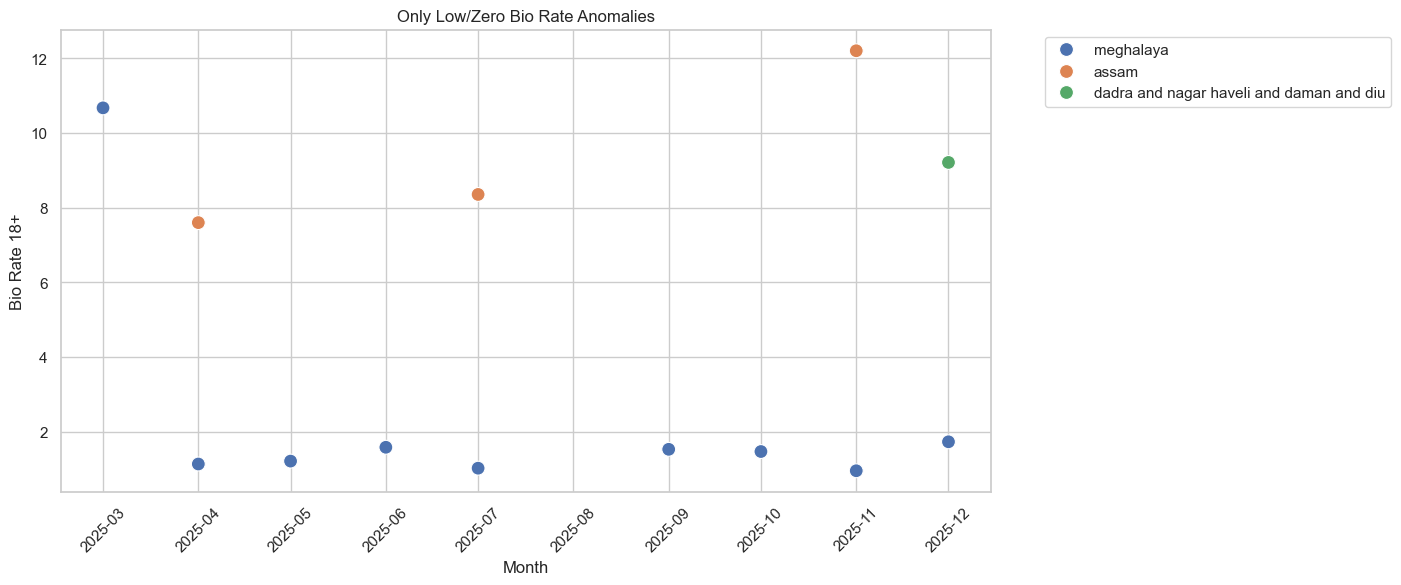

<Figure size 1000x500 with 0 Axes>

In [17]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=anomalies, x='month', y='bio_rate_18p', hue='state', s=100)
plt.title('Only Low/Zero Bio Rate Anomalies')
plt.xlabel('Month')
plt.ylabel('Bio Rate 18+')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
plt.savefig("zero_bio_rate_anomalies.png", dpi=300)


### Graph Interpretation: Anomalies Scatter Plot

This scatter plot visualizes anomalous biometric completion records across time and geography:

- **X-axis (Month)**: Shows when anomalies occur, revealing temporal patterns
- **Y-axis (Bio Rate 18+)**: The magnitude of the anomaly (how low the completion rate is)
- **Colors (States)**: Distinguishes which state each anomaly belongs to, revealing geographic concentration
- **Point Position**: Clustered points indicate either persistent problems in specific states or timing-related issues

Key observations:
- Horizontal clustering at y=0 indicates complete data collection failures
- States with many scattered points have frequent anomalies and need structural improvements
- Temporal clustering suggests organization-wide issues (e.g., system downtime, policy changes)
- Isolated anomalies might be state-specific operational challenges

## Time Series with Anomalies by State (Chunked)

Create line plots for each state grouped in chunks of 10, highlighting anomalies in red. Use log scale on y-axis for better visibility of lower values.

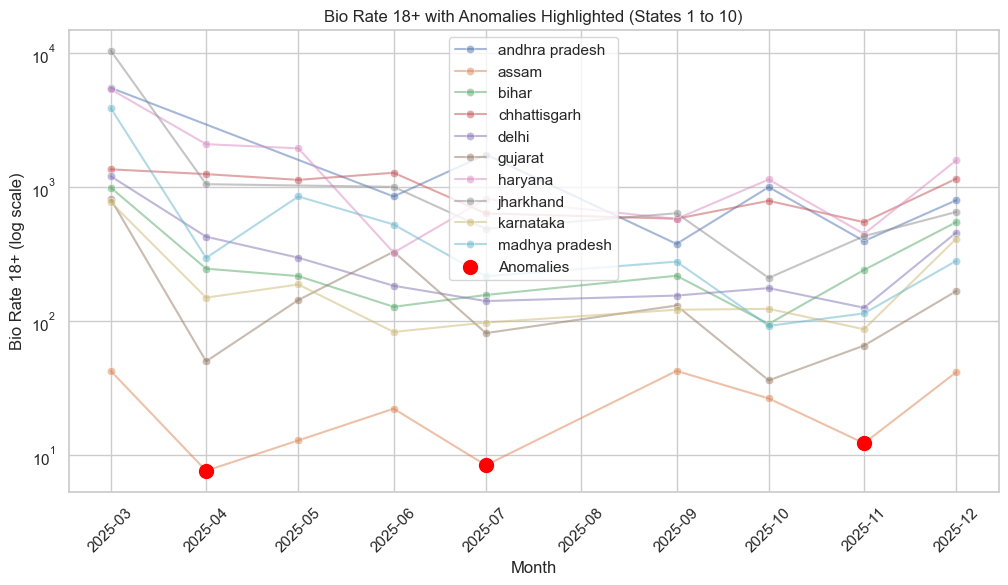

<Figure size 1000x500 with 0 Axes>

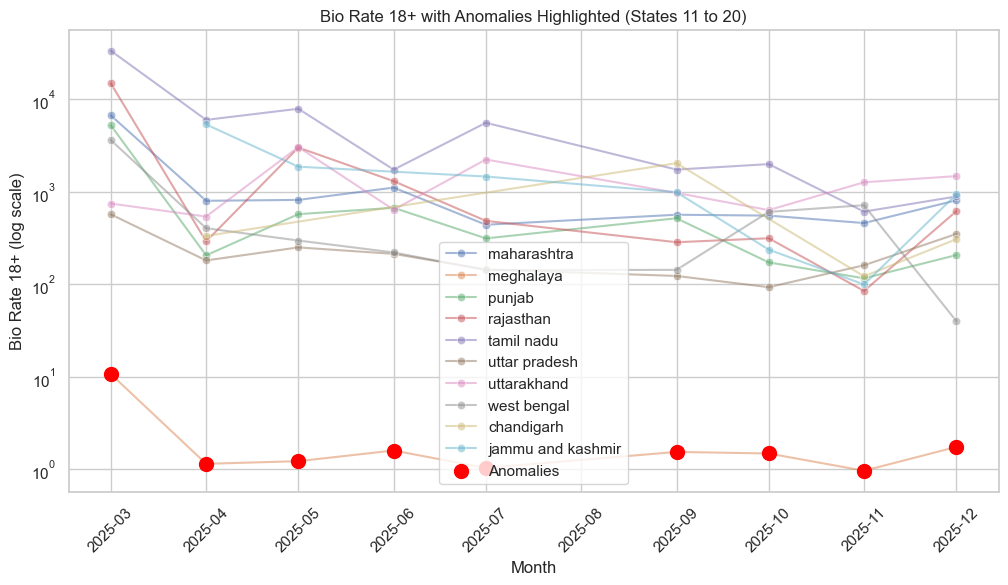

<Figure size 1000x500 with 0 Axes>

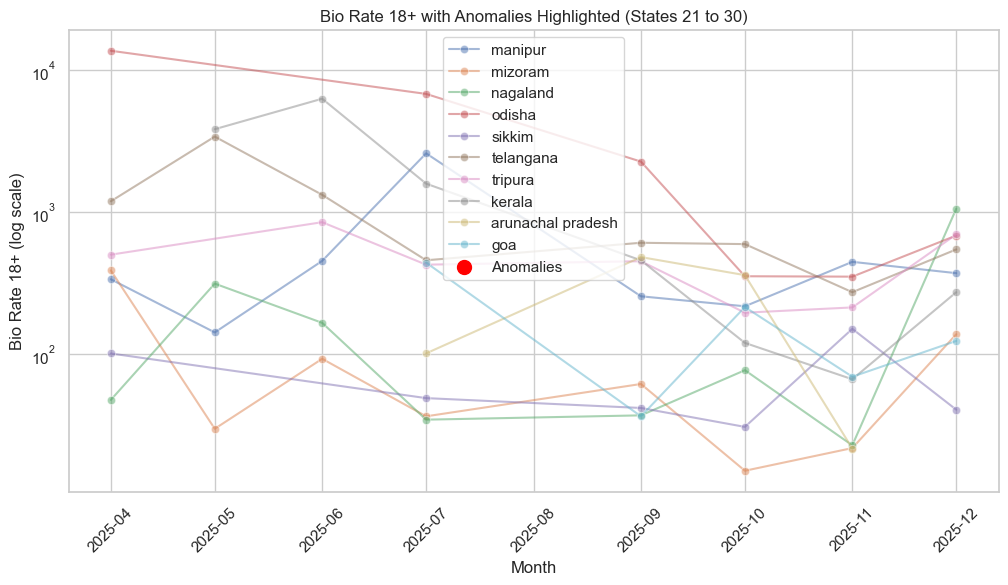

<Figure size 1000x500 with 0 Axes>

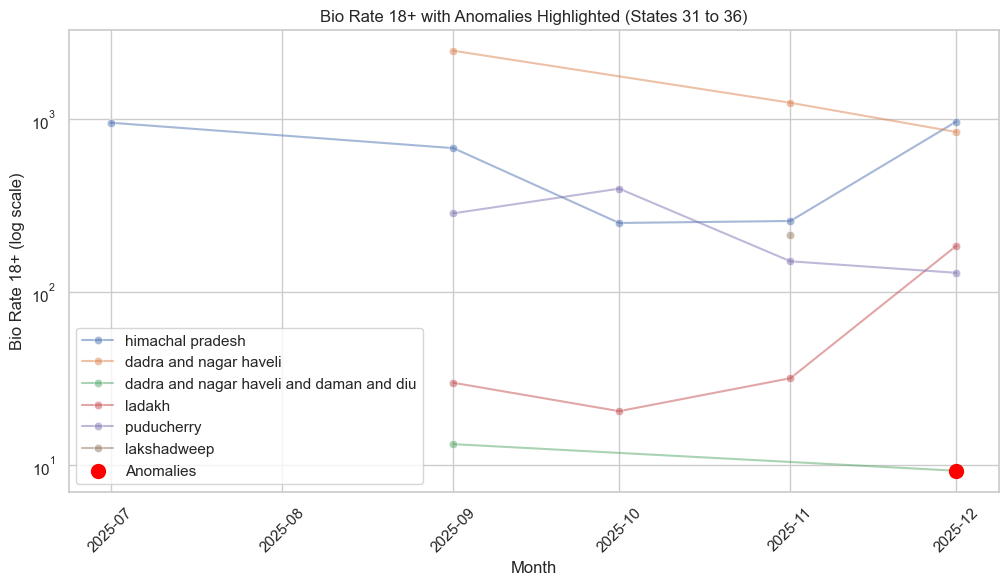

<Figure size 1000x500 with 0 Axes>

In [18]:
# Get unique states
states = df['state'].unique()
n_states_per_plot = 10

# Split states into chunks of 10
for i in range(0, len(states), n_states_per_plot):
    states_chunk = states[i:i + n_states_per_plot]
    
    plt.figure(figsize=(12, 6))
    
    # Filter df for current chunk
    df_chunk = df[df['state'].isin(states_chunk)]
    anomalies_chunk = anomalies[anomalies['state'].isin(states_chunk)]
    
    # Plot lines
    sns.lineplot(data=df_chunk, x='month', y='bio_rate_18p', hue='state', marker='o', alpha=0.5)
    
    # Plot anomalies
    plt.scatter(anomalies_chunk['month'], anomalies_chunk['bio_rate_18p'], 
                color='red', label='Anomalies', s=100, zorder=5)
    
    plt.yscale('log')
    plt.title(f'Bio Rate 18+ with Anomalies Highlighted (States {i+1} to {i+len(states_chunk)})')
    plt.xlabel('Month')
    plt.ylabel('Bio Rate 18+ (log scale)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    plt.savefig(f"bio_rate_18p_states_{i+1}_to_{i+len(states_chunk)}.png", dpi=300) 


### Graph Interpretation: Time Series by State with Anomalies (Multiple Plots)

These line plots show the monthly biometric completion rate trend for each state:

**X-axis (Month)**: Temporal progression of data collection

**Y-axis (Bio Rate 18+ on log scale)**: Using logarithmic scale allows visualization of both very small and large values, making it easier to spot anomalies even when they're near zero

**Lines (colored by state)**: Each line traces one state's performance over time, with:
- Upward trends indicating improving data collection capacity
- Downward trends indicating declining performance or operational issues
- Flat lines suggesting stable but potentially problematic performance

**Red Scatter Points (Anomalies)**: Highlighted in red, these show state-month combinations with critically low biometric completion rates

**Log Scale Advantage**: Especially useful because biometric rates can vary from near-zero to over 1000, and the log scale compresses extreme values, making patterns more visible. A point at log scale y=0 represents rate≈1, y=2 represents rate≈7, y=3 represents rate≈20, etc.

This chunked approach (10 states per plot) prevents overcrowding and makes state-level patterns more discernible.

## Log-Transformed Distribution Visualization

Compare two approaches for visualizing biometric completion rates: direct log-transformation of values and logarithmic binning with linear data representation.

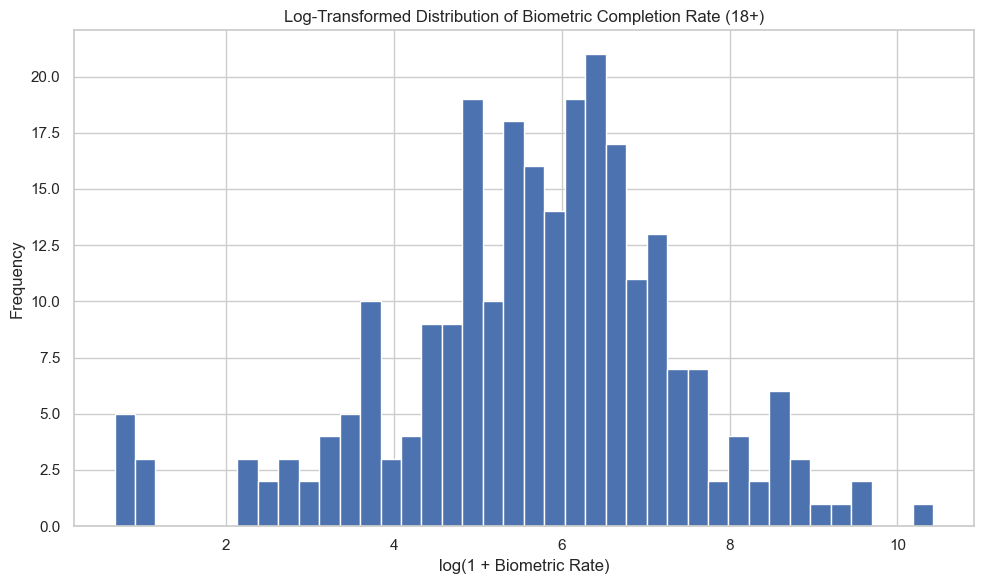

In [19]:
plt.figure(figsize=(10,6))
plt.hist(np.log1p(df['bio_rate_18p'].dropna()), bins=40)

plt.xlabel("log(1 + Biometric Rate)")
plt.ylabel("Frequency")
plt.title("Log-Transformed Distribution of Biometric Completion Rate (18+)")

plt.tight_layout()
plt.show()


### Graph Interpretation: Log-Transformed Distribution (Method 1)

This histogram uses **direct log-transformation** of the biometric rate values using `log(1 + rate)`:

**Key Features**:
- **X-axis (log transformed scale)**: Shows the natural logarithm of (1 + biometric rate), transforming the original values to a compressed scale
- **Y-axis (Frequency)**: Count of data points in each bin using standard linear scale
- **Purpose**: Converts highly skewed data into a more symmetric distribution for better visualization

**Why log(1+x) instead of log(x)**:
- The `log1p()` function handles zero values safely without undefined logarithms
- Preserves the relationship between zero-rate and positive rates
- Helps identify whether data follows a log-normal distribution

**Interpretation Benefits**:
- Very low completion rates (near 0) get expanded and more visible
- High completion rates get compressed, preventing the visualization from being dominated by a few extreme values
- Reveals the true shape of the distribution underlying the original skewed data
- Useful for detecting multimodal distributions hidden in right-skewed data

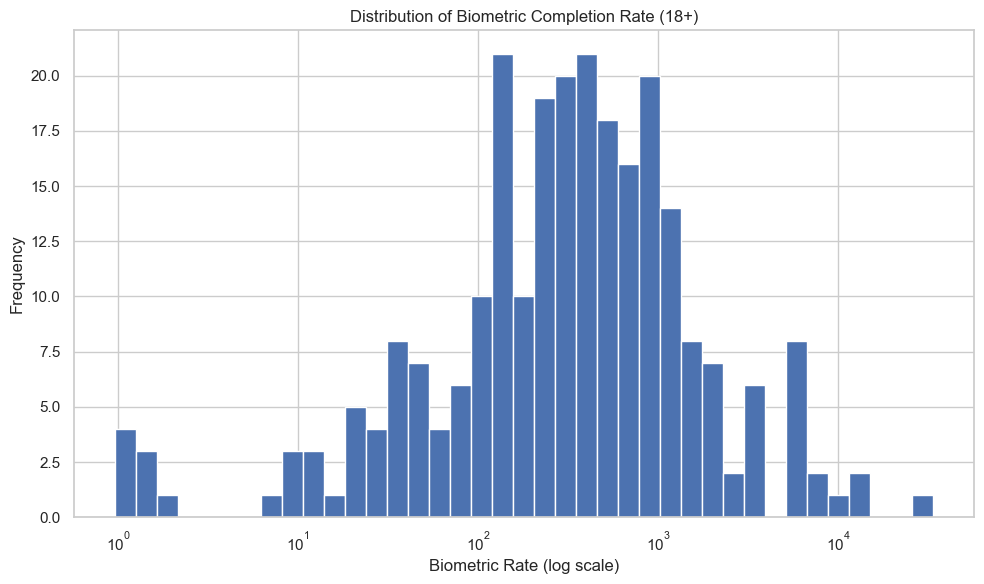

In [26]:
data = df['bio_rate_18p'].dropna()

bins = np.logspace(
    np.log10(data[data > 0].min()),
    np.log10(data.max()),
    40
)

plt.figure(figsize=(10,6))
plt.hist(data, bins=bins)

plt.xscale('log')

plt.xlabel("Biometric Rate (log scale)")
plt.ylabel("Frequency")
plt.title("Distribution of Biometric Completion Rate (18+)")

plt.tight_layout()
plt.show()


### Graph Interpretation: Logarithmic Binning Distribution (Method 2)

This histogram uses **logarithmic binning** with linear data representation using `np.logspace()`:

**Key Features**:
- **X-axis (log scale)**: Binning edges are created logarithmically, so lower values get more bins (finer granularity) and higher values get fewer bins
- **Y-axis (Frequency)**: Count of data points in each logarithmically-spaced bin
- **Purpose**: Provides equal representation across the full range from minimum to maximum values

**How Logarithmic Binning Works**:
- `np.logspace()` creates 40 bins evenly distributed on a logarithmic scale from min to max
- Near-zero values (which dominate the dataset) get more granular representation
- Large values are grouped into wider bins, preventing empty bins
- The x-axis scale is then converted to log using `plt.xscale('log')`

**Interpretation Benefits**:
- **Reveals structure at extremes**: Both very small and very large completion rates are clearly visible
- **Avoids empty bins**: Unlike linear binning with wide gaps, log binning ensures all regions have meaningful representation
- **Better for power-law data**: Ideal when data spans multiple orders of magnitude
- **Comparative advantage**: Easier to spot multimodal behavior across the entire range than the direct transformation method

**Visual Comparison**: 
- Method 1 (log-transform values) emphasizes distribution shape after transformation
- Method 2 (log-scale bins) preserves original data values while adjusting bin size for visibility

## Correlation Matrix Analysis

Calculate and visualize the correlation between enrollment count, demographic completion rate, and biometric completion rate for 18+ age group.

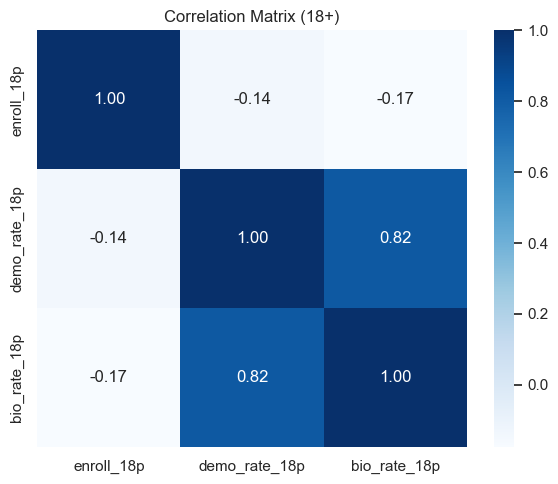

In [21]:
corr = df[['enroll_18p','demo_rate_18p','bio_rate_18p']].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix (18+)")
plt.tight_layout()
plt.savefig("correlation_matrix_18plus.png", dpi=300)
plt.show()


### Graph Interpretation: Correlation Matrix Heatmap

This heatmap displays the correlation coefficients between three key variables for the 18+ age group:

**Variables Shown**:
- **enroll_18p**: Number of enrollments in the 18+ age group
- **demo_rate_18p**: Demographic completion rate (percentage of enrollments with demographic data)
- **bio_rate_18p**: Biometric completion rate (percentage of enrollments with biometric data)

**Color Interpretation**:
- **Dark Blue (1.0)**: Perfect positive correlation - as one variable increases, the other increases proportionally
- **Light Blue (0.0)**: No correlation - changes in one variable are unrelated to the other
- **Values closer to -1** (not visible here if all positive): Negative correlation - as one increases, the other decreases

**Key Insights**:
- High correlation between demo_rate and bio_rate suggests they scale together (when demographic collection improves, biometric tends to improve)
- Correlation with enroll_18p reveals whether completion rates depend on enrollment volume
- Understanding these relationships helps in predicting impacts of interventions on related metrics
- A correlation near 1.0 suggests redundancy; a correlation near 0 suggests independent factors

## Distribution of State Averages

Visualize the distribution of average biometric completion rates per state using a histogram with a threshold line marked.

In [24]:
state_avg = (
    df.groupby('state', as_index=False)['bio_rate_18p']
      .mean()
      .rename(columns={'bio_rate_18p': 'avg_bio_rate'})
)

threshold = 200

state_avg['risk_flag'] = (state_avg['avg_bio_rate'] < threshold).astype(int)

risk_states = state_avg[state_avg['risk_flag'] == 1]

# Combine
#risk_states = pd.concat([risk_states, non_risk_states]).sort_index()

display(risk_states)



,state,avg_bio_rate,risk_flag
2,assam,23.944017,1
7,dadra and nagar haveli and daman and diu,11.178571,1
9,goa,176.236733,1
17,ladakh,66.716667,1
22,meghalaya,2.370918,1
23,mizoram,97.465236,1
29,sikkim,68.466200,1


### Table Interpretation: High-Risk States Ranking

The displayed table lists all states classified as high-risk (average biometric completion rate < 200):

**Columns Explained**:
- **state**: Name of the state
- **avg_bio_rate**: Average biometric completion rate across all months (lower values = worse performance)
- **risk_flag**: Binary indicator (1 = high-risk, classified as needing intervention)

**How to Use This Table**:
- **Identification**: Quickly identify which states need urgent attention
- **Prioritization**: States with the lowest avg_bio_rate require the most critical interventions
- **Benchmarking**: Compare state performance relative to the 200-unit threshold
- **Action Planning**: Use this to allocate resources, technical support, and capacity-building efforts

States appearing in this table should be prioritized for:
- Infrastructure improvements
- Staff training and capacity building
- Process optimization
- Operational troubleshooting
- Policy or procedural reviews

The magnitude of shortfall (how much below 200) indicates the severity and potential effort required for improvement.

## Visualize High-Risk States

Create a horizontal bar chart showing states with biometric completion rates below the risk threshold, sorted for readability.

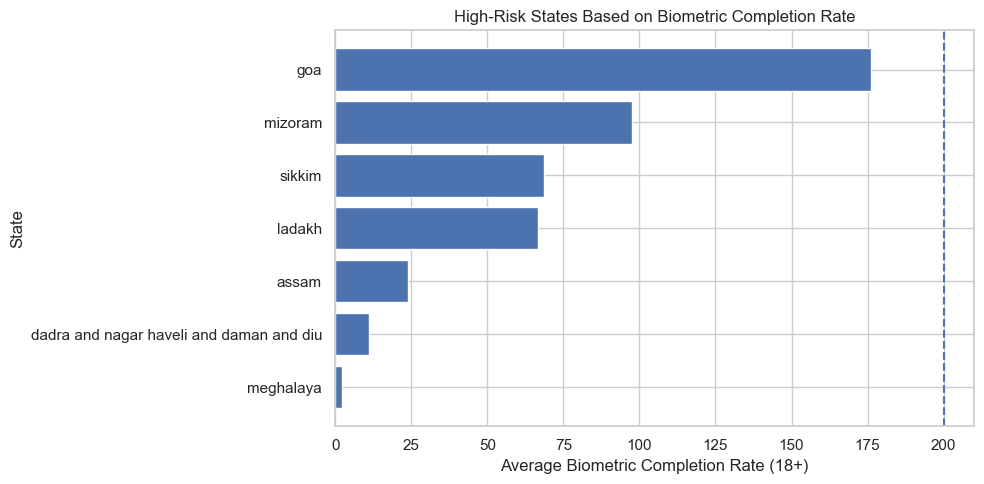

<Figure size 1000x500 with 0 Axes>

In [25]:
# Sort for better readability
risk_states_sorted = risk_states.sort_values('avg_bio_rate')

plt.figure(figsize=(10, 5))
plt.barh(
    risk_states_sorted['state'],
    risk_states_sorted['avg_bio_rate']
)

# Threshold line
plt.axvline(threshold, linestyle='--')

plt.xlabel('Average Biometric Completion Rate (18+)')
plt.ylabel('State')
plt.title('High-Risk States Based on Biometric Completion Rate')

plt.tight_layout()
plt.show()
plt.savefig("high_risk_states_biometric_completion_18plus.png", dpi=300)    


### Graph Interpretation: High-Risk States Bar Chart

This horizontal bar chart visualizes the performance of all high-risk states (those below the 200-unit threshold):

**X-axis (Average Biometric Completion Rate)**: The average biometric rate for each state
- Longer bars = better (but still below threshold)
- Shorter bars = worse (more critical attention needed)

**Y-axis (State Names)**: Listed in sorted order from worst (bottom) to best (top) among risk states

**Red Dashed Threshold Line**: Marks the 200-unit boundary
- All bars end to the left of this line by definition (these are high-risk states)
- The distance from each bar to the threshold indicates how much improvement is needed

**Insight for Action Planning**:
- **States with very short bars** (far from threshold): Require fundamental structural reforms, significant resource investment, and sustained support
- **States near the threshold**: Incremental improvements could move them into compliance
- **Geographic clustering**: If many neighboring states are high-risk, it might indicate regional challenges (policy, infrastructure, training) requiring coordinated multi-state solutions

This chart is invaluable for prioritizing intervention efforts and resource allocation strategies.

## Export Analysis Results

Save the processed and analyzed dataset to a CSV file for further use and reference.

In [ ]:
df.to_csv("aadhaar_analysis_output.csv", index=False)